# Introduction to the usage of SiModIn models 
[SiModIn GitHub](https://github.com/HaSchneider/SiModIn) <br />
[SiModIn PyPi](https://pypi.org/project/simodin/)


Using the example of a steam distribution model. This model is made for:
- calculate temperature dependent impact of process heat from steam 
- export temperature dependent activity for process heat from steam to brightway dataset 

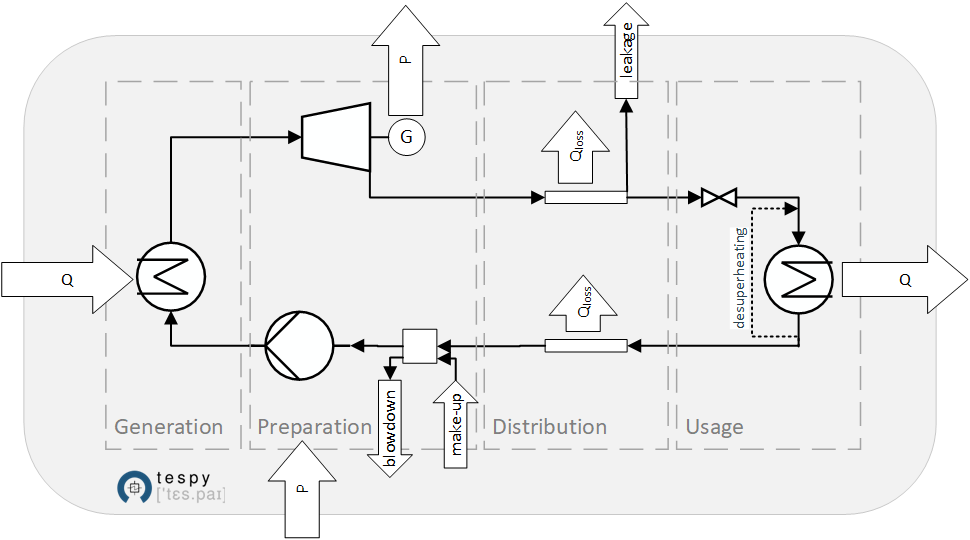

Figure 1: Steam net topology. The arrows crosing the system boundary represents the flows considered for LCA.

## 1. Setup of the model:

In [ ]:
from steam_net import steam_net_interface as sni
import bw2data as bd
from simodin import interface as smi

Initiate concrete SimModel class:

In [ ]:
my_model= sni.steam_net('steam net')

Check bibtex like reference for citation (only placeholder now) or description for more information:  

In [ ]:
my_model.reference

In [ ]:
my_model.description

And initiate the model:

In [ ]:
my_model.init_model()

Now, the configured parameters can be shown. They can be passed to the calculate_model() method, in the initialising of the concrete class or the init_model() method as key word arguments. If nothing is passed, the default parameters are used. In this model, they can be passed as typical data types, like float or strings, but also as pint quantities (except the temperature, due to data preprocessing steps).

In [ ]:
my_model.params

In [ ]:
my_model.calculate_model(needed_temperature= 230, 
                         wind_velocity=4, 
                         heat=my_model.ureg.Quantity(40, 'MW'), 
                         insulation_thickness=my_model.ureg.Quantity(0.15, 'm'))

After calculation of the model, technosphere and biosphere flows can be created by calling the abstract method define_flows(). This method could execute the extractor functions if used: 

In [ ]:
my_model.define_flows()

As you can see here, the electricity produced in the back pressure turbine is substituted and thereby handled as credit to handle the multifunctionality. Thats the reason, why the amount is negative:

In [ ]:
my_model.technosphere

In [ ]:
my_model.biosphere

The flexibility of SiModIn allows adding own functions in concrete SimModel class, like plot the T-s diagramm of the steam distribution model for technical analysis and debuging:

In [ ]:
plot=my_model.plot_Ts()

## 2. Assign brightway datasets

For linking to brightway, a modelInterface class needs to be created. The SimModel concrete instance needs to be passed as argumnet: 

In [ ]:
my_interface= smi.modelInterface('steam_net', my_model)

One or more methods needs to be defined:

In [ ]:
my_interface.methods=[('ecoinvent-3.11',  'EF v3.1',  'climate change',  'global warming potential (GWP100)')]

Now, the desired brightway datasets needs to be linked to the technosphere flows. For that, we choose some suitable datasets:

In [ ]:
bd.projects.set_current('bw_meets_tespy')
ei=bd.Database('ecoinvent-3.11-cutoff')

Heat production by natural gas, one of the major heat source for process heat today:

In [ ]:
ei_heat=[act for act in ei if 'heat production, natural gas, at industrial furnace >100kW' in act['name']
 and 'Europe without Switzerland' in act['location'] 
 ][0]
ei_heat

In [ ]:
ei_electricity=[act for act in ei if 'market for electricity, medium' in act['name']
                and 'municipal' not in act['name']
                and 'DE' in act['location'] ][0]
ei_electricity

Also biosphere flows needs to be assigned. We add the water disposal from physical losses as biosphere flow:

In [ ]:
bio=bd.Database('ecoinvent-3.11-biosphere')
water_bio=bio.get('51254820-3456-4373-b7b4-056cf7b16e01')

Now, the datasets are added to the technosphere flows by the interface function 'add_dataset()':

In [ ]:
my_interface.add_dataset('steam generation',ei_heat)
my_interface.add_dataset('electricity grid',ei_electricity)
my_interface.add_dataset('electricity substitution',ei_electricity)
my_interface.add_dataset('steam leak',water_bio)

## 3a.) Calculate model impact

For faster computation, the background datasets are calculated once before:

In [ ]:
my_interface.calculate_background_impact()

Afterwards the overall impact can be calculated:

In [ ]:
my_interface.calculate_impact()

In [ ]:
my_model.technosphere

In [ ]:
my_model._technosphere['distributed steam'].impact

### Change reference unit

The automatic unit transformation allows an easy adjusting of the reference flow unit. This can be done by change the model_unit attribute of the functional unit flow to [a pint compatible unit](https://github.com/hgrecco/pint/blob/master/pint/default_en.txt): 

In [ ]:
my_model.set_flow_attr('distributed steam', 'model_unit','kilothermochemical_british_thermal_unit')

my_interface.calculate_impact()

### Switch to allocation

If you wan to consider allocation instead of substitution, the model already provides the calculation of allocation factor based on exergy losses due to the product flows:

In [ ]:
my_model.alloc_ex

To configure the interface for allocation:
- create a new technosphere flow for the produced electricity with the property "functional" =True, so that it will be recognized as product flow
- define the allocation factors 
- remove the dataset from the substituted electricity flow, so that it is not handled as substitution

In [ ]:
my_model._technosphere['electricity production']=smi.technosphere_edge(
                name='electricity production',
                source= my_model,
                target= None,
                amount= lambda: my_model.model.get_conn("e_turb_grid").E._val*my_model.model.units.ureg.second ,
                type= smi.technosphereTypes.product,
                functional= True
                )

In [ ]:
my_model.set_flow_attr('electricity production', 'allocationfactor', 1- my_model.alloc_ex)
my_model.set_flow_attr('distributed steam', 'allocationfactor', my_model.alloc_ex)

my_interface.remove_dataset('electricity substitution')

In [ ]:
my_interface.calculate_impact()

In [ ]:
my_model.technosphere

## 3b.) Export to brightway

The model can now be exported as brightway dataset by executing the 'export_to_bw()' function. 

A database in which the dataset should be exported can be passed as argument. If nothing is passed, a new database called simodin_db is created. 

Next to that, an identifier for the activity code can be passed. Per default, an code will be created by the name of the mode, the name of the functional flow, and a timestamp.

In [ ]:
code=my_interface.export_to_bw()

In [ ]:
code

In [ ]:
sim_db=bd.Database('simodin_db')

In [ ]:
my_dataset=sim_db.get(code[0])

In [ ]:
[ex for ex in my_dataset.exchanges()]